In [1]:
import os
import numpy as np
import random
import traceback
import multiprocessing
import json
import logging
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor
import json
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.metrics.pairwise import (
    euclidean_distances as ed,
    cosine_distances as cd,
    cosine_similarity as cs,
    manhattan_distances as md,
)

from pyeer.eer_info import get_eer_stats

import torch
import torch.nn.functional as F
from pytorch_metric_learning.distances import LpDistance, CosineSimilarity, SNRDistance

# Set visible device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# ===================================
# Core Functions
# ===================================

def EERf(genuine, impostor):
    genuine = np.array(genuine).ravel()
    impostor = np.array(impostor).ravel()
    stats_a = get_eer_stats(genuine, impostor)
    return stats_a.eer, stats_a.fmr100


def calculate_and_print_averages(genuine, impostor):
    eer_values = []
    for key in genuine.keys():
        re = EERf(genuine[key], impostor[key])
        eer_values.append(re[0])
    average_eer = np.mean(eer_values) * 100
    std_eer = np.std(eer_values) * 100
    return average_eer, std_eer


def compute_embedding_batch_two(x_test_batch, embedding_network, batch_size=100, device="cuda"):
    return x_test_batch


def calculate_similarity_scores_two(enrollment_embeddings, y_enrollment, verification_embeddings, y_verification, distance):
    similarity_results_by_class = []
    similarity_results_by_class_dict = defaultdict(list)
    unique_classes = np.unique(y_enrollment)
    class_indices = [np.where(y_enrollment == cls)[0] for cls in unique_classes]

    if distance == "cd":
        similarity_matrix = -1 * cd(verification_embeddings, enrollment_embeddings)
    elif distance == "ed":
        similarity_matrix = -1 * ed(verification_embeddings, enrollment_embeddings)

    for i in range(similarity_matrix.shape[0]):
        current_class = y_verification[i]
        predicted_scores = similarity_matrix[i]

        for cls in unique_classes:
            same_class_indices = class_indices[np.where(unique_classes == cls)[0][0]]
            max_score = sum(sorted(predicted_scores[same_class_indices], reverse=True)[:40]) / 40
            if current_class != cls:
                similarity_results_by_class.append([max_score, 0, current_class, cls, i])
                similarity_results_by_class_dict[cls].append([max_score])

    return similarity_results_by_class, similarity_results_by_class_dict


def assessment_model_data_two(enrollment_data, ye, verification_data, yv, e_network, distance):
    enrollment_embeddings = compute_embedding_batch_two(enrollment_data, e_network)
    verification_embeddings = compute_embedding_batch_two(verification_data, e_network)
    similarity_results_by_class, similarity_results_by_class_dict = calculate_similarity_scores_two(
        enrollment_embeddings, ye, verification_embeddings, yv, distance
    )
    return similarity_results_by_class, similarity_results_by_class_dict


def prepare_data_for_evaluation(x_e, y_e, s_e, h_e, x_v, y_v, s_v, h_v):
    x_data = np.concatenate([x_e, x_v], axis=0)
    y_data = np.concatenate([y_e, y_v], axis=0)
    s_data = np.concatenate([s_e, s_v], axis=0)
    h_data = np.concatenate([h_e, h_v], axis=0)
    return x_data, y_data, s_data, h_data


def create_enrollment_verification_similarity(data, labels, days, interval, s_data, h_data):
    def is_numeric(value):
        try:
            int(value)
            return True
        except ValueError:
            return False

    valid_indices = np.array([is_numeric(d) for d in days])
    if not valid_indices.any():
        raise ValueError("No valid numeric entries in the `days` array.")

    days = days[valid_indices].astype(int)
    data = data[valid_indices]
    labels = labels[valid_indices]
    s_data = s_data[valid_indices]
    h_data = h_data[valid_indices]

    unique_subjects = np.unique(labels)
    similarity_results = defaultdict(list)

    for subject in unique_subjects:
        subject_indices = labels == subject
        subject_days = days[subject_indices]
        subject_data = data[subject_indices]
        subject_sessions = s_data[subject_indices]
        subject_headset = h_data[subject_indices]

        sorted_indices = np.argsort(subject_days)
        subject_days = subject_days[sorted_indices]
        subject_data = subject_data[sorted_indices]
        subject_sessions = subject_sessions[sorted_indices]
        subject_headset = subject_headset[sorted_indices]

        unique_pairs = np.unique(list(zip(subject_sessions, subject_headset)), axis=0)

        for enrollment_session, enrollment_headset in unique_pairs:
            enrollment_indices = (subject_sessions == int(enrollment_session)) & (subject_headset == enrollment_headset)
            enrollment_data = subject_data[enrollment_indices]
            enrollment_day = subject_days[enrollment_indices][0]

            verification_indices = np.where((subject_days - enrollment_day == interval))[0]
            if len(verification_indices) > 0:
                for i2 in verification_indices:
                    verification_sample = subject_data[i2]
                    if verification_sample.ndim == 1:
                        verification_sample = verification_sample.reshape(1, -1)

                    distances = -1 * ed(enrollment_data, verification_sample)
                    max_score = sum(sorted(distances, reverse=True)[:40]) / 40
                    similarity_results[subject].append([float(max_score[0])])

    flat_results = []
    for cls in similarity_results:
        flat_results.extend(similarity_results[cls])
    
    print("Total pairs:", len(flat_results), "Subjects:", len(similarity_results.keys()))
    return similarity_results


def calculate_eer_for_single_range(day_range):
    try:
        print(f"Started processing range: {day_range}")
        combined_results = defaultdict(list)
        for days in day_range:
            results = create_enrollment_verification_similarity(x_data, y_data, s_data, days, s_data, h_data)
            for key, value in results.items():
                combined_results[key].extend(value)

        flat_results = []
        for cls in combined_results:
            flat_results.extend(combined_results[cls])

        total_pairs = len(flat_results)
        print(f"Processed range: {day_range}, Total pairs: {total_pairs}, Subjects: {len(combined_results.keys())}")
        return calculate_and_print_averages(combined_results, impostor), len(combined_results.keys()), total_pairs
    except Exception as e:
        print(f"Error in processing range {day_range}: {e}", exc_info=True)
        raise


def process_period(args):
    period, idx, day_range = args
    try:
        print(f"Started processing {period}, interval {idx}, range {day_range}")
        eerstd, subjectn, samplen = calculate_eer_for_single_range(day_range)
        eer, std = eerstd[0], eerstd[1]
        print(f"Finished processing {period}, interval {idx}: EER = {eer:.4f} ± {std:.4f}")
        return {
            "period": period,
            "interval": idx,
            "day_range": list(day_range),
            "eer": eer,
            "std": std,
            "subject_number": subjectn,
            "sample_number": samplen,
        }
    except Exception as e:
        print(f"Error in processing {args}: {e}", exc_info=True)
        raise




In [8]:
# ===================================
# Load Data
# ===================================
from utils_evaluation import (
    generate_embeddings,
    compute_similarity_scores,
    evaluate_eer_per_class,
    get_enrollment_verification_indices
)

x_test_e = np.load('./files/x_test_e.npy')
y_test_e = np.load('./files/y_test_e.npy')
s_test_e = np.load('./files/s_test_e.npy')
h_test_e = np.load('./files/h_test_e.npy')

x_test_v = np.load('./files/x_test_v.npy')
y_test_v = np.load('./files/y_test_v.npy')
s_test_v = np.load('./files/s_test_v.npy')
h_test_v = np.load('./files/h_test_v.npy')

print(x_test_e.shape, y_test_e.shape, s_test_e.shape, h_test_e.shape)
print(x_test_v.shape, y_test_v.shape, s_test_v.shape, h_test_v.shape)

X_all = np.concatenate([x_test_e, x_test_v], axis=0)
Y_all = np.concatenate([y_test_e, y_test_v], axis=0)
S_all = np.concatenate([s_test_e, s_test_v], axis=0)
H_all = np.concatenate([h_test_e, h_test_v], axis=0)

mask = H_all == b'HydroCe'
X_all = X_all[mask]
Y_all = Y_all[mask]
S_all = S_all[mask]
H_all = H_all[mask]  # optional if not used later


# Enroll/Verify split (by index)
enroll_idxs, verify_idxs = get_enrollment_verification_indices(Y_all, S_all)

# Reconstruct final datasets, matching original variable names
x_test_e = X_all[enroll_idxs]
y_test_e = Y_all[enroll_idxs]
s_test_e = S_all[enroll_idxs]
h_test_e = H_all[enroll_idxs]

x_test_v = X_all[verify_idxs]
y_test_v = Y_all[verify_idxs]
s_test_v = S_all[verify_idxs]
h_test_v = H_all[verify_idxs]


(10000, 256) (10000,) (10000,) (10000,)
(160051, 256) (160051,) (160051,) (160051,)


In [9]:
results2, impostor = assessment_model_data_two(x_test_e, y_test_e, x_test_v, y_test_v, None, distance='ed')

# Prepare unified data for full evaluation
x_data, y_data, s_data, h_data = prepare_data_for_evaluation(
    x_test_e, y_test_e, s_test_e, h_test_e, x_test_v, y_test_v, s_test_v, h_test_v
)

Prepared 26 tasks for processing.
Started processing days_1_to_7, interval 1, range [1]
Started processing range: [1]
Total pairs: 19908 Subjects: 54
Processed range: [1], Total pairs: 19908, Subjects: 54
Finished processing days_1_to_7, interval 1: EER = 4.9334 ± 4.2391
Started processing days_1_to_7, interval 2, range [2]
Started processing range: [2]
Total pairs: 15900 Subjects: 50
Processed range: [2], Total pairs: 15900, Subjects: 50
Finished processing days_1_to_7, interval 2: EER = 6.0504 ± 5.4334
Started processing days_1_to_7, interval 3, range [3]
Started processing range: [3]
Total pairs: 14308 Subjects: 43
Processed range: [3], Total pairs: 14308, Subjects: 43
Finished processing days_1_to_7, interval 3: EER = 6.1035 ± 5.2078
Started processing days_1_to_7, interval 4, range [4]
Started processing range: [4]
Total pairs: 13400 Subjects: 48
Processed range: [4], Total pairs: 13400, Subjects: 48
Finished processing days_1_to_7, interval 4: EER = 7.0469 ± 6.8931
Started proces

/home/fallahi/anaconda3/lib/python3.12/site-packages/pyeer/eer_stats.py:220: UserWarning: It is possible that you had set the wrong score type. Please consider reviewing if you are using dissimilarity or similarity scores
  warn("It is possible that you had set the wrong score"


Finished processing weeks_2_to_4, interval 2: EER = 7.9947 ± 7.4015
Started processing weeks_2_to_4, interval 3, range range(22, 29)
Started processing range: range(22, 29)
Total pairs: 10208 Subjects: 36
Total pairs: 7800 Subjects: 32
Total pairs: 6308 Subjects: 22
Total pairs: 8100 Subjects: 32
Total pairs: 7700 Subjects: 35
Total pairs: 9800 Subjects: 37
Total pairs: 16508 Subjects: 46
Processed range: range(22, 29), Total pairs: 66424, Subjects: 53
Finished processing weeks_2_to_4, interval 3: EER = 8.6012 ± 5.9480
Started processing months_2_to_12, interval 1, range range(29, 59)
Started processing range: range(29, 59)
Total pairs: 8408 Subjects: 36
Total pairs: 5800 Subjects: 25
Total pairs: 5508 Subjects: 27
Total pairs: 5800 Subjects: 30
Total pairs: 6700 Subjects: 32
Total pairs: 6600 Subjects: 33
Total pairs: 14600 Subjects: 43
Total pairs: 6200 Subjects: 32
Total pairs: 5000 Subjects: 27
Total pairs: 3900 Subjects: 23
Total pairs: 4400 Subjects: 23
Total pairs: 4900 Subjects

/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


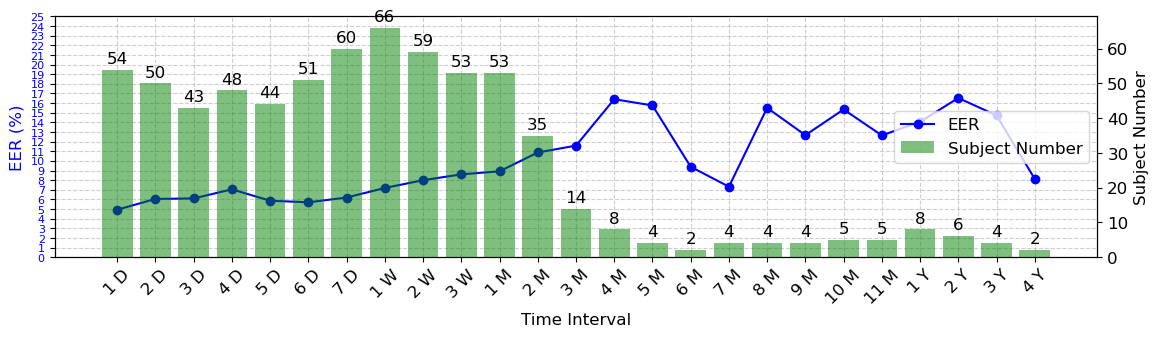

In [10]:


# ===================================
# Main Evaluation Loop
# ===================================

if __name__ == "__main__":
    try:
        multiprocessing.set_start_method("spawn", force=True)

        time_intervals = {
            "days_1_to_7": [[1], [2], [3], [4], [5], [6], [7]],
            "weeks_2_to_4": [
                range(8, 15),
                range(15, 22),
                range(22, 29),
            ],
            "months_2_to_12": [
                range(29, 59), range(59, 89), range(89, 119),
                range(119, 149), range(149, 179), range(179, 209),
                range(209, 239), range(239, 269), range(269, 299),
                range(299, 329), range(329, 359),
            ],
            "years_2_to_6": [
                range(365, 730), range(730, 1095),
                range(1095, 1460), range(1460, 1825), range(1825, 2190),
            ],
        }

        eer_results = {}
        tasks = []

        for period, ranges in time_intervals.items():
            for idx, day_range in enumerate(ranges, start=1):
                tasks.append((period, idx, day_range))

        print(f"Prepared {len(tasks)} tasks for processing.")

        results = []
        for task in tasks:
            results.append(process_period(task))

        for result in results:
            period = result["period"]
            if period not in eer_results:
                eer_results[period] = []
            eer_results[period].append(result)

        output_file = "./Results/eer_results_HydroCe.json"
        with open(output_file, "w") as f:
            json.dump(eer_results, f, indent=4)

        print(f"EER results saved to {output_file}")

    except Exception as e:
        print(f"Critical error in main execution: {e}", exc_info=True)




    # 1. Load data directly into final_data with dict comprehension (simpler and more pythonic)
    with open('./Results/eer_results_HydroCe.json', 'r') as f:
        new_data = json.load(f)
    
    final_data = {
        period: [
            {
                'period': entry['period'],
                'interval': entry['interval'],
                'eer': entry['eer'],
                'std': entry['std'],
                'subject_number': entry['subject_number'],
                'sample_number': entry['sample_number']
            }
            for entry in entries
        ]
        for period, entries in new_data.items()
    }
    
    # 2. Simplify filtering using dictionary comprehension and list comprehension
    filtered_data = {
        period: [
            entry for entry in entries 
            if not (entry['period'] == 'years_2_to_6' and entry['interval'] in [5])
        ]
        for period, entries in final_data.items()
    }
    
    # Remove empty periods
    filtered_data = {k: v for k, v in filtered_data.items() if v}
    
    # 3. Flatten data directly with list comprehension
    plot_data = [entry for entries in filtered_data.values() for entry in entries]
    
    # 4. Extract fields for plotting
    intervals = [item["interval"] for item in plot_data]
    eers = [item["eer"] for item in plot_data]
    stds = [item["std"] for item in plot_data]
    subject_numbers = [item["subject_number"] for item in plot_data]
    sample_numbers = [item["sample_number"] for item in plot_data]
    period_labels = [item["period"] for item in plot_data]
    
    # 5. Simplify label generation
    period_mapping = {
        'days_1_to_7': 'D',
        'weeks_2_to_4': 'W',
        'months_2_to_12': 'M',
        'years_2_to_6': 'Y'
    }
    
    x_labels = [
        f"{interval} {period_mapping[period]}" for interval, period in zip(intervals, period_labels)
    ]
    
    # 6. Plotting code unchanged except for minor simplifications
    fig, ax1 = plt.subplots(figsize=(11.69, 3.5))
    
    ax1.errorbar(
        x_labels, eers, fmt='o-', color='blue', ecolor='lightblue',
        elinewidth=2, capsize=4, label='EER'
    )
    ax1.set_xlabel('Time Interval', fontsize=12) 
    ax1.set_ylabel('EER (%)', color='blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=8)
    ax1.set_ylim(0, 25)
    ax1.set_yticks(range(0, 26, 1))
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    ax2 = ax1.twinx()
    bars = ax2.bar(x_labels, subject_numbers, color='green', alpha=0.5, label='Subject Number')
    ax2.set_ylabel('Subject Number', color='black', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='black', labelsize=12)
    
    for bar, subject_number in zip(bars, subject_numbers):
        ax2.text(
            bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
            str(subject_number), ha='center', va='bottom', fontsize=12
        )
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center right', fontsize=12)
    
    ax1.set_xticks(range(len(x_labels)))
    ax1.set_xticklabels(x_labels, rotation=45, ha='center', fontsize=12)
    
    plt.subplots_adjust(bottom=0.4)
    plt.tight_layout()
    #plt.savefig('./Results/time_intervals_HydroCe.pdf', format='pdf', dpi=300)
    plt.show()


(10000, 256) (10000,) (10000,) (10000,)
(160051, 256) (160051,) (160051,) (160051,)
Prepared 26 tasks for processing.
Started processing days_1_to_7, interval 1, range [1]
Started processing range: [1]
Total pairs: 4200 Subjects: 22
Processed range: [1], Total pairs: 4200, Subjects: 22
Finished processing days_1_to_7, interval 1: EER = 4.6612 ± 4.1279
Started processing days_1_to_7, interval 2, range [2]
Started processing range: [2]
Total pairs: 3079 Subjects: 19
Processed range: [2], Total pairs: 3079, Subjects: 19
Finished processing days_1_to_7, interval 2: EER = 6.7049 ± 7.2273
Started processing days_1_to_7, interval 3, range [3]
Started processing range: [3]
Total pairs: 4700 Subjects: 21
Processed range: [3], Total pairs: 4700, Subjects: 21
Finished processing days_1_to_7, interval 3: EER = 5.7760 ± 3.2132
Started processing days_1_to_7, interval 4, range [4]
Started processing range: [4]
Total pairs: 3400 Subjects: 17
Processed range: [4], Total pairs: 3400, Subjects: 17
Finis

/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 100 Subjects: 1
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 100 Subjects: 1
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects:

/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


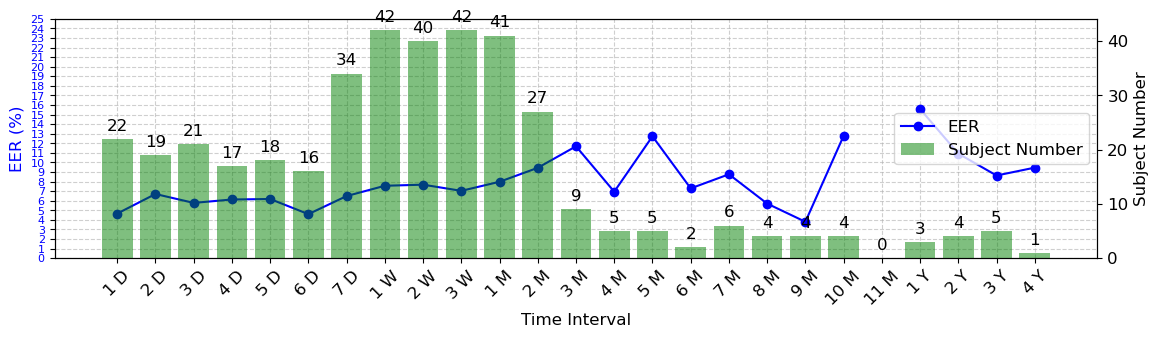

In [11]:
# ===================================
# Load Data
# ===================================
from utils_evaluation import (
    generate_embeddings,
    compute_similarity_scores,
    evaluate_eer_per_class,
    get_enrollment_verification_indices
)

x_test_e = np.load('./files/x_test_e.npy')
y_test_e = np.load('./files/y_test_e.npy')
s_test_e = np.load('./files/s_test_e.npy')
h_test_e = np.load('./files/h_test_e.npy')

x_test_v = np.load('./files/x_test_v.npy')
y_test_v = np.load('./files/y_test_v.npy')
s_test_v = np.load('./files/s_test_v.npy')
h_test_v = np.load('./files/h_test_v.npy')

print(x_test_e.shape, y_test_e.shape, s_test_e.shape, h_test_e.shape)
print(x_test_v.shape, y_test_v.shape, s_test_v.shape, h_test_v.shape)

X_all = np.concatenate([x_test_e, x_test_v], axis=0)
Y_all = np.concatenate([y_test_e, y_test_v], axis=0)
S_all = np.concatenate([s_test_e, s_test_v], axis=0)
H_all = np.concatenate([h_test_e, h_test_v], axis=0)

mask = H_all == b'Geodisi'
X_all = X_all[mask]
Y_all = Y_all[mask]
S_all = S_all[mask]
H_all = H_all[mask]  # optional if not used later


# Enroll/Verify split (by index)
enroll_idxs, verify_idxs = get_enrollment_verification_indices(Y_all, S_all)

# Reconstruct final datasets, matching original variable names
x_test_e = X_all[enroll_idxs]
y_test_e = Y_all[enroll_idxs]
s_test_e = S_all[enroll_idxs]
h_test_e = H_all[enroll_idxs]

x_test_v = X_all[verify_idxs]
y_test_v = Y_all[verify_idxs]
s_test_v = S_all[verify_idxs]
h_test_v = H_all[verify_idxs]

results2, impostor = assessment_model_data_two(x_test_e, y_test_e, x_test_v, y_test_v, None, distance='ed')

# Prepare unified data for full evaluation
x_data, y_data, s_data, h_data = prepare_data_for_evaluation(
    x_test_e, y_test_e, s_test_e, h_test_e, x_test_v, y_test_v, s_test_v, h_test_v
)
# ===================================
# Main Evaluation Loop
# ===================================

if __name__ == "__main__":
    try:
        multiprocessing.set_start_method("spawn", force=True)

        time_intervals = {
            "days_1_to_7": [[1], [2], [3], [4], [5], [6], [7]],
            "weeks_2_to_4": [
                range(8, 15),
                range(15, 22),
                range(22, 29),
            ],
            "months_2_to_12": [
                range(29, 59), range(59, 89), range(89, 119),
                range(119, 149), range(149, 179), range(179, 209),
                range(209, 239), range(239, 269), range(269, 299),
                range(299, 329), range(329, 359),
            ],
            "years_2_to_6": [
                range(365, 730), range(730, 1095),
                range(1095, 1460), range(1460, 1825), range(1825, 2190),
            ],
        }

        eer_results = {}
        tasks = []

        for period, ranges in time_intervals.items():
            for idx, day_range in enumerate(ranges, start=1):
                tasks.append((period, idx, day_range))

        print(f"Prepared {len(tasks)} tasks for processing.")

        results = []
        for task in tasks:
            results.append(process_period(task))

        for result in results:
            period = result["period"]
            if period not in eer_results:
                eer_results[period] = []
            eer_results[period].append(result)

        output_file = "./Results/eer_results_Geodisi.json"
        with open(output_file, "w") as f:
            json.dump(eer_results, f, indent=4)

        print(f"EER results saved to {output_file}")

    except Exception as e:
        print(f"Critical error in main execution: {e}", exc_info=True)




    # 1. Load data directly into final_data with dict comprehension (simpler and more pythonic)
    with open('./Results/eer_results_Geodisi.json', 'r') as f:
        new_data = json.load(f)
    
    final_data = {
        period: [
            {
                'period': entry['period'],
                'interval': entry['interval'],
                'eer': entry['eer'],
                'std': entry['std'],
                'subject_number': entry['subject_number'],
                'sample_number': entry['sample_number']
            }
            for entry in entries
        ]
        for period, entries in new_data.items()
    }
    
    # 2. Simplify filtering using dictionary comprehension and list comprehension
    filtered_data = {
        period: [
            entry for entry in entries 
            if not (entry['period'] == 'years_2_to_6' and entry['interval'] in [5])
        ]
        for period, entries in final_data.items()
    }
    
    # Remove empty periods
    filtered_data = {k: v for k, v in filtered_data.items() if v}
    
    # 3. Flatten data directly with list comprehension
    plot_data = [entry for entries in filtered_data.values() for entry in entries]
    
    # 4. Extract fields for plotting
    intervals = [item["interval"] for item in plot_data]
    eers = [item["eer"] for item in plot_data]
    stds = [item["std"] for item in plot_data]
    subject_numbers = [item["subject_number"] for item in plot_data]
    sample_numbers = [item["sample_number"] for item in plot_data]
    period_labels = [item["period"] for item in plot_data]
    
    # 5. Simplify label generation
    period_mapping = {
        'days_1_to_7': 'D',
        'weeks_2_to_4': 'W',
        'months_2_to_12': 'M',
        'years_2_to_6': 'Y'
    }
    
    x_labels = [
        f"{interval} {period_mapping[period]}" for interval, period in zip(intervals, period_labels)
    ]
    
    # 6. Plotting code unchanged except for minor simplifications
    fig, ax1 = plt.subplots(figsize=(11.69, 3.5))
    
    ax1.errorbar(
        x_labels, eers, fmt='o-', color='blue', ecolor='lightblue',
        elinewidth=2, capsize=4, label='EER'
    )
    ax1.set_xlabel('Time Interval', fontsize=12) 
    ax1.set_ylabel('EER (%)', color='blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=8)
    ax1.set_ylim(0, 25)
    ax1.set_yticks(range(0, 26, 1))
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    ax2 = ax1.twinx()
    bars = ax2.bar(x_labels, subject_numbers, color='green', alpha=0.5, label='Subject Number')
    ax2.set_ylabel('Subject Number', color='black', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='black', labelsize=12)
    
    for bar, subject_number in zip(bars, subject_numbers):
        ax2.text(
            bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
            str(subject_number), ha='center', va='bottom', fontsize=12
        )
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center right', fontsize=12)
    
    ax1.set_xticks(range(len(x_labels)))
    ax1.set_xticklabels(x_labels, rotation=45, ha='center', fontsize=12)
    
    plt.subplots_adjust(bottom=0.4)
    plt.tight_layout()
    #plt.savefig('./Results/time_intervals_HydroCe.pdf', format='pdf', dpi=300)
    plt.show()


(10000, 256) (10000,) (10000,) (10000,)
(160051, 256) (160051,) (160051,) (160051,)
Prepared 26 tasks for processing.
Started processing days_1_to_7, interval 1, range [1]
Started processing range: [1]
Total pairs: 10800 Subjects: 23
Processed range: [1], Total pairs: 10800, Subjects: 23
Finished processing days_1_to_7, interval 1: EER = 17.1241 ± 8.2693
Started processing days_1_to_7, interval 2, range [2]
Started processing range: [2]
Total pairs: 10500 Subjects: 21
Processed range: [2], Total pairs: 10500, Subjects: 21
Finished processing days_1_to_7, interval 2: EER = 18.8552 ± 9.0062
Started processing days_1_to_7, interval 3, range [3]
Started processing range: [3]
Total pairs: 10100 Subjects: 23
Processed range: [3], Total pairs: 10100, Subjects: 23
Finished processing days_1_to_7, interval 3: EER = 16.0942 ± 8.1727
Started processing days_1_to_7, interval 4, range [4]
Started processing range: [4]
Total pairs: 9500 Subjects: 23
Processed range: [4], Total pairs: 9500, Subjects:

/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Processed range: range(209, 239), Total pairs: 0, Subjects: 0
Finished processing months_2_to_12, interval 7: EER = nan ± nan
Started processing months_2_to_12, interval 8, range range(239, 269)
Started processing range: range(239, 269)
Total p

/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/fallahi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
Total pairs: 0 Subjects: 0
T

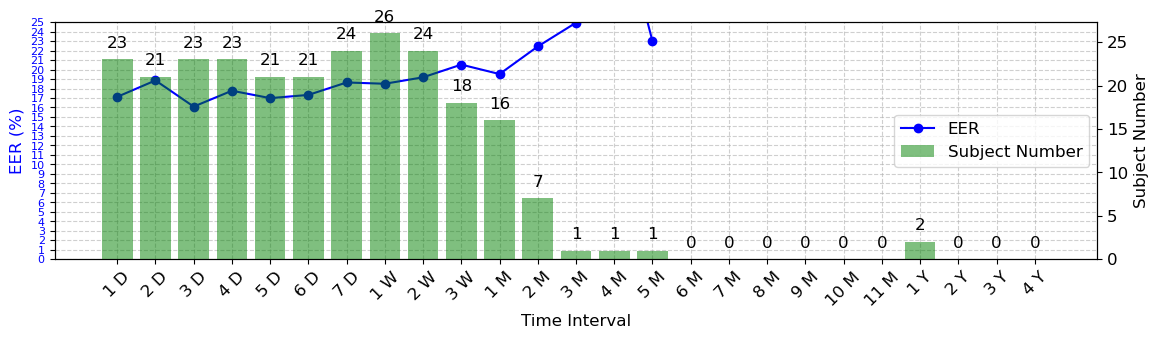

In [12]:
# ===================================
# Load Data
# ===================================
from utils_evaluation import (
    generate_embeddings,
    compute_similarity_scores,
    evaluate_eer_per_class,
    get_enrollment_verification_indices
)

x_test_e = np.load('./files/x_test_e.npy')
y_test_e = np.load('./files/y_test_e.npy')
s_test_e = np.load('./files/s_test_e.npy')
h_test_e = np.load('./files/h_test_e.npy')

x_test_v = np.load('./files/x_test_v.npy')
y_test_v = np.load('./files/y_test_v.npy')
s_test_v = np.load('./files/s_test_v.npy')
h_test_v = np.load('./files/h_test_v.npy')

print(x_test_e.shape, y_test_e.shape, s_test_e.shape, h_test_e.shape)
print(x_test_v.shape, y_test_v.shape, s_test_v.shape, h_test_v.shape)

X_all = np.concatenate([x_test_e, x_test_v], axis=0)
Y_all = np.concatenate([y_test_e, y_test_v], axis=0)
S_all = np.concatenate([s_test_e, s_test_v], axis=0)
H_all = np.concatenate([h_test_e, h_test_v], axis=0)

mask = H_all == b'BioSemi'
X_all = X_all[mask]
Y_all = Y_all[mask]
S_all = S_all[mask]
H_all = H_all[mask]  # optional if not used later


# Enroll/Verify split (by index)
enroll_idxs, verify_idxs = get_enrollment_verification_indices(Y_all, S_all)

# Reconstruct final datasets, matching original variable names
x_test_e = X_all[enroll_idxs]
y_test_e = Y_all[enroll_idxs]
s_test_e = S_all[enroll_idxs]
h_test_e = H_all[enroll_idxs]

x_test_v = X_all[verify_idxs]
y_test_v = Y_all[verify_idxs]
s_test_v = S_all[verify_idxs]
h_test_v = H_all[verify_idxs]

results2, impostor = assessment_model_data_two(x_test_e, y_test_e, x_test_v, y_test_v, None, distance='ed')

# Prepare unified data for full evaluation
x_data, y_data, s_data, h_data = prepare_data_for_evaluation(
    x_test_e, y_test_e, s_test_e, h_test_e, x_test_v, y_test_v, s_test_v, h_test_v
)
# ===================================
# Main Evaluation Loop
# ===================================

if __name__ == "__main__":
    try:
        multiprocessing.set_start_method("spawn", force=True)

        time_intervals = {
            "days_1_to_7": [[1], [2], [3], [4], [5], [6], [7]],
            "weeks_2_to_4": [
                range(8, 15),
                range(15, 22),
                range(22, 29),
            ],
            "months_2_to_12": [
                range(29, 59), range(59, 89), range(89, 119),
                range(119, 149), range(149, 179), range(179, 209),
                range(209, 239), range(239, 269), range(269, 299),
                range(299, 329), range(329, 359),
            ],
            "years_2_to_6": [
                range(365, 730), range(730, 1095),
                range(1095, 1460), range(1460, 1825), range(1825, 2190),
            ],
        }

        eer_results = {}
        tasks = []

        for period, ranges in time_intervals.items():
            for idx, day_range in enumerate(ranges, start=1):
                tasks.append((period, idx, day_range))

        print(f"Prepared {len(tasks)} tasks for processing.")

        results = []
        for task in tasks:
            results.append(process_period(task))

        for result in results:
            period = result["period"]
            if period not in eer_results:
                eer_results[period] = []
            eer_results[period].append(result)

        output_file = "./Results/eer_results_BioSemi.json"
        with open(output_file, "w") as f:
            json.dump(eer_results, f, indent=4)

        print(f"EER results saved to {output_file}")

    except Exception as e:
        print(f"Critical error in main execution: {e}", exc_info=True)




    # 1. Load data directly into final_data with dict comprehension (simpler and more pythonic)
    with open('./Results/eer_results_BioSemi.json', 'r') as f:
        new_data = json.load(f)
    
    final_data = {
        period: [
            {
                'period': entry['period'],
                'interval': entry['interval'],
                'eer': entry['eer'],
                'std': entry['std'],
                'subject_number': entry['subject_number'],
                'sample_number': entry['sample_number']
            }
            for entry in entries
        ]
        for period, entries in new_data.items()
    }
    
    # 2. Simplify filtering using dictionary comprehension and list comprehension
    filtered_data = {
        period: [
            entry for entry in entries 
            if not (entry['period'] == 'years_2_to_6' and entry['interval'] in [5])
        ]
        for period, entries in final_data.items()
    }
    
    # Remove empty periods
    filtered_data = {k: v for k, v in filtered_data.items() if v}
    
    # 3. Flatten data directly with list comprehension
    plot_data = [entry for entries in filtered_data.values() for entry in entries]
    
    # 4. Extract fields for plotting
    intervals = [item["interval"] for item in plot_data]
    eers = [item["eer"] for item in plot_data]
    stds = [item["std"] for item in plot_data]
    subject_numbers = [item["subject_number"] for item in plot_data]
    sample_numbers = [item["sample_number"] for item in plot_data]
    period_labels = [item["period"] for item in plot_data]
    
    # 5. Simplify label generation
    period_mapping = {
        'days_1_to_7': 'D',
        'weeks_2_to_4': 'W',
        'months_2_to_12': 'M',
        'years_2_to_6': 'Y'
    }
    
    x_labels = [
        f"{interval} {period_mapping[period]}" for interval, period in zip(intervals, period_labels)
    ]
    
    # 6. Plotting code unchanged except for minor simplifications
    fig, ax1 = plt.subplots(figsize=(11.69, 3.5))
    
    ax1.errorbar(
        x_labels, eers, fmt='o-', color='blue', ecolor='lightblue',
        elinewidth=2, capsize=4, label='EER'
    )
    ax1.set_xlabel('Time Interval', fontsize=12) 
    ax1.set_ylabel('EER (%)', color='blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=8)
    ax1.set_ylim(0, 25)
    ax1.set_yticks(range(0, 26, 1))
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    ax2 = ax1.twinx()
    bars = ax2.bar(x_labels, subject_numbers, color='green', alpha=0.5, label='Subject Number')
    ax2.set_ylabel('Subject Number', color='black', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='black', labelsize=12)
    
    for bar, subject_number in zip(bars, subject_numbers):
        ax2.text(
            bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
            str(subject_number), ha='center', va='bottom', fontsize=12
        )
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center right', fontsize=12)
    
    ax1.set_xticks(range(len(x_labels)))
    ax1.set_xticklabels(x_labels, rotation=45, ha='center', fontsize=12)
    
    plt.subplots_adjust(bottom=0.4)
    plt.tight_layout()
    #plt.savefig('./Results/time_intervals_HydroCe.pdf', format='pdf', dpi=300)
    plt.show()
